In [2]:

import pandas as pd
from pandas import Series,DataFrame

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

In [3]:
West_train = pd.read_csv("train.csv")
Test_df = pd.read_csv("test.csv")
Sample_Submission = pd.read_csv("sampleSubmission.csv")
weather = pd.read_csv("weather.csv")

In [4]:
West_train.info()
print "--------------------------"
Test_df.info()
print "--------------------------"
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null object
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 1.0+ MB
--------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 11 columns):
Id                        116293 non-null int64
Date                      116293 non-null object
Address             

In [5]:
#Taking the integer value of latitude and longitude

West_train['Lat_int'] = West_train.Latitude.apply(int)
West_train['Long_int'] = West_train.Longitude.apply(int)
Test_df['Lat_int'] = Test_df.Latitude.apply(int)
Test_df['Long_int'] = Test_df.Longitude.apply(int)


In [6]:
weather.drop("CodeSum",axis=1,inplace=True)

In [7]:
# Splitting station 1 and 2 and join horizontally
weather_stn1 = weather[weather['Station']==1]
weather_stn2 = weather[weather['Station']==2]
weather_stn1 = weather_stn1.drop('Station', axis=1)
weather_stn2 = weather_stn2.drop('Station', axis=1)
weather = weather_stn1.merge(weather_stn2, on='Date')


In [8]:
# replace some missing values and T with -1
weather = weather.replace('M', -1)
weather = weather.replace('-', -1)
weather = weather.replace('T', -1)
weather = weather.replace(' T', -1)
weather = weather.replace('  T', -1)

In [9]:

def create_month(x):
    return x.split('-')[1]

def create_day(x):
    return x.split('-')[2]

def create_year(x):
    return x.split('-')[0]

In [10]:
West_train.head(1)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Lat_int,Long_int
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,41,-87


In [11]:
West_train['Month'] = West_train.Date.apply(create_month)
West_train['Day'] = West_train.Date.apply(create_day)
West_train['Year'] = West_train.Date.apply(create_year)

Test_df['Month'] = Test_df.Date.apply(create_month)
Test_df['Day'] = Test_df.Date.apply(create_day)
Test_df['Year'] = Test_df.Date.apply(create_year)

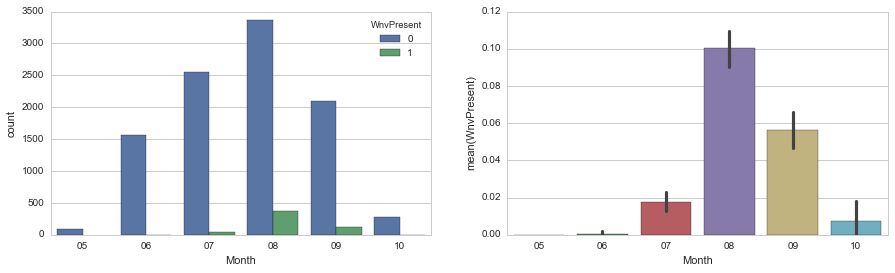

In [12]:
#Check which month had the most number of West Nile Virus present
fig,(axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.countplot(x='Month', data=West_train, hue="WnvPresent", ax=axis1)
sns.barplot(x='Month',y='WnvPresent',data=West_train, ax=axis2)


With this visualization we can say that the month of august has most cases of west nile virus to be positive.

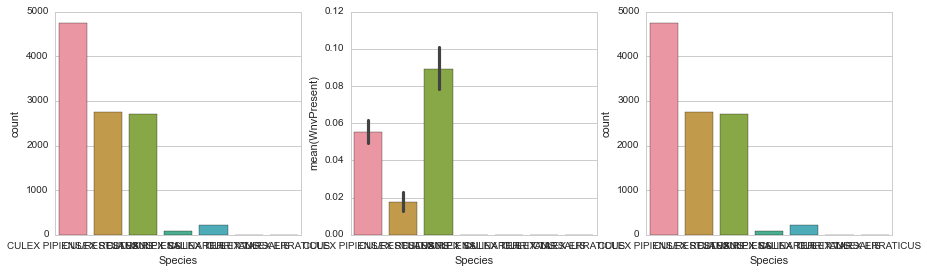

In [13]:
#Check which month had the most number of West Nile Virus present
fig,(axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,4))
sns.countplot(x='Species', data=West_train, ax=axis1)
sns.barplot(x='Species',y='WnvPresent',data=West_train, ax=axis2)

#Checking the number of cases each month where West Nile virus test was positive
sns.countplot(x='Species', data=West_train, ax=axis3)

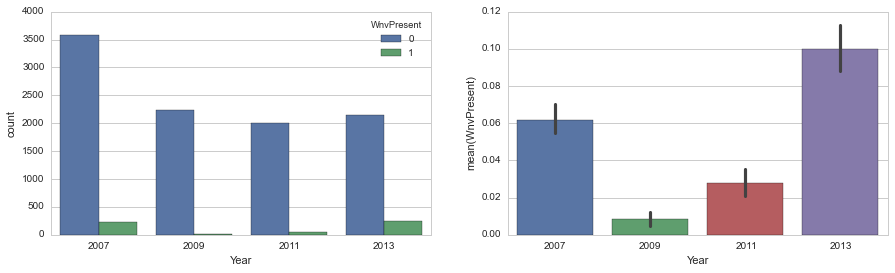

In [14]:
#Check which month had the most number of West Nile Virus present
fig,(axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.countplot(x='Year', data=West_train, hue="WnvPresent", ax=axis1)
sns.barplot(x='Year',y='WnvPresent',data=West_train, ax=axis2)

In [15]:
# Merge with weather data
West_train = West_train.merge(weather, on='Date')
Test_df = Test_df.merge(weather, on='Date')
West_train = West_train.drop(['Date'], axis = 1)
Test_df = Test_df.drop(['Date'], axis = 1)


In [16]:
# Convert categorical data to numbers
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
lbl.fit(list(West_train['Species'].values) + list(Test_df['Species'].values))
West_train['Species'] = lbl.transform(West_train['Species'].values)
Test_df['Species'] = lbl.transform(Test_df['Species'].values)

lbl.fit(list(West_train['Address'].values) + list(Test_df['Address'].values))
West_train['Address'] = lbl.transform(West_train['Address'].values)
Test_df['Address'] = lbl.transform(Test_df['Address'].values)

lbl.fit(list(West_train['Trap'].values) + list(Test_df['Trap'].values))
West_train['Trap'] = lbl.transform(West_train['Trap'].values)
Test_df['Trap'] = lbl.transform(Test_df['Trap'].values)


In [17]:
# drop columns
West_train = West_train.drop(['Street', 'AddressNumberAndStreet', 'NumMosquitos','Latitude','Longitude'], axis = 1)
Test_df = Test_df.drop(['Street', 'AddressNumberAndStreet','Latitude','Longitude'], axis = 1)


In [18]:
# drop columns with -1s
West_train = West_train.ix[:,(West_train != -1).any(axis=0)]
Test_df = Test_df.ix[:,(Test_df != -1).any(axis=0)]

In [19]:
# define training and testing sets

X_train = West_train.drop('WnvPresent',axis=1)
Y_train = West_train['WnvPresent']
X_test  = Test_df.drop("Id",axis=1).copy()

In [20]:
X_train.head(1)

,Address,Species,Block,Trap,AddressAccuracy,Lat_int,Long_int,Month,Day,Year,...,DewPoint_y,WetBulb_y,Heat_y,Cool_y,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y
0,68,2,41,1,9,41,-87,05,29,2007,...,59,66,0,12,0.00,29.44,30.09,5.8,16,7.4


In [21]:
X_test.head(1)

,Address,Species,Block,Trap,AddressAccuracy,Lat_int,Long_int,Month,Day,Year,...,DewPoint_y,WetBulb_y,Heat_y,Cool_y,PrecipTotal_y,StnPressure_y,SeaLevel_y,ResultSpeed_y,ResultDir_y,AvgSpeed_y
0,68,2,41,1,9,41,-87,06,11,2008,...,55,64,0,11,0.00,29.34,29.97,9.4,18,10.4


In [22]:
# Random Forests

random_forest = RandomForestClassifier(n_estimators=200)

clf = random_forest.fit(X_train, Y_train)



In [23]:
from sklearn import metrics
from sklearn import cross_validation
scores = cross_validation.cross_val_score(clf, X_train, Y_train,
                                          cv=4, scoring='accuracy')
scores

array([ 0.8180434 ,  0.9474686 ,  0.52493338,  0.10133333])

In [24]:
Y_pred = random_forest.predict_proba(X_test)

random_forest.score(X_train, Y_train)

0.98105844279459353

In [66]:
submission = pd.DataFrame({
        "Id":Test_df["Id"],
        "WnvPresent": Y_pred
        
    })
submission.to_csv('ResultR.csv', index=False)